In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from PIL import Image
import random
import math
import matplotlib.pyplot as plt
import dendropy
import csv
from dendropy.calculate import treecompare
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


# Loading Data

In [2]:
X_test = np.load('../../Data_Preprocessing/output/500_Dataset/X_test_seed_30.npy')
X_train = np.load('../../Data_Preprocessing/output/500_Dataset/X_train_seed_30.npy')
Y_test_flatten = np.load('../../Data_Preprocessing/output/500_Dataset/Y_test_flatten_seed_30.npy')
Y_train_flatten = np.load('../../Data_Preprocessing/output/500_Dataset/Y_train_flatten_seed_30.npy')

In [3]:
BRANCH_NUM = 100
SEQUENCE_LEN = 1000

OUTPUT_DIST_NUM = int((BRANCH_NUM - 1) * BRANCH_NUM / 2)

In [4]:
print('X_train.shape : ', X_train.shape)
print('X_test.shape : ', X_test.shape)

print('Y_train_flatten.shape : ', Y_train_flatten.shape)
print('Y_test_flatten.shape : ', Y_test_flatten.shape)# Training Testing Dataset Partition

X_train.shape :  (425, 100, 1000, 1)
X_test.shape :  (75, 100, 1000, 1)
Y_train_flatten.shape :  (425, 4950)
Y_test_flatten.shape :  (75, 4950)


### Plot for shuffled (500 samples)
#### X_train

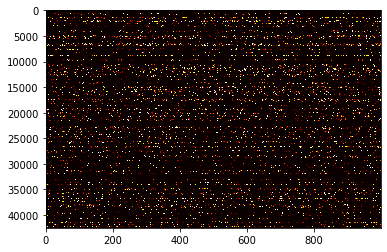

In [5]:
plt.imshow(X_train.reshape((X_train.shape[0]*100, 1000)), cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### Plot for shuffled (500 samples)
#### X_test

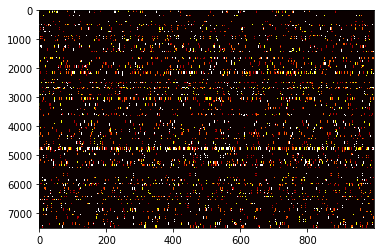

In [6]:
plt.imshow(X_test.reshape((X_test.shape[0]*100, 1000)), cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### Load Data

In [7]:
model = Sequential()

# Layer 1
model.add(Conv2D(100, input_shape=X_train.shape[1:], kernel_size=(100,1), strides=(1,1)))
#model.add(Conv2D(48, input_shape=(400,11,1), kernel_size=(2,2), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))

# Layer 2
model.add(Dense(1200))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Layer 3
model.add(Dense(1200))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Layer 4
model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Layer 5
model.add(Flatten())
model.add(Dense(OUTPUT_DIST_NUM, activation='relu'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1000, 100)      10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1000, 100)      400       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1000, 100)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1000, 100)      0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1000, 1200)     121200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 1000, 1200)     4800      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 1000, 1200)    

In [9]:
# def log_loss:
#     if not K.is_tensor(y_pred):
#         y_pred = K.constant(y_pred)
#     y_true = K.cast(y_true, y_pred.dtype)
    
#     return K.log(K.square(y_pred - y_true), axis=-1)

In [10]:
# (4) Compile 
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['accuracy'])

In [11]:
loss_list_epoch= []
RF_avg_distance_epoch = []
RF_list_distance_epoch = []

In [12]:
## This function is defined for vector -> symmetric distance matrix
def utri2mat(utri):
    n = (int(-1 + np.sqrt(1 + 8*len(utri))) // 2) + 1
    iu1 = np.triu_indices(n-1)
    iu1 = (iu1[0], iu1[1] + 1)
    ret = np.zeros((n, n))
    ret[iu1] = utri
    ret.T[iu1] = utri
    return ret

In [13]:
X_test.shape

(75, 100, 1000, 1)

In [14]:
# Do first time to initial the tree!
print("******** Start fitting model ********")
history = model.fit(X_train, Y_train_flatten, validation_data=(X_test, Y_test_flatten), batch_size=50, epochs=1, verbose=1)
print(history.history['loss'])
loss_list_epoch.append(history.history['loss'][0])

print("******** Start calculating RF Distance ********")
RF_list_distance = []
for index in range(len(X_train)):
    tips_num = np.count_nonzero(np.sum(X_train[index], axis=1) != 0) 
#         print("tips_num: ", tips_num)
    array_selection_length = int((tips_num + 1) * tips_num / 2)
    Y_train_flatten_vec_sel = Y_train_flatten[index][0:array_selection_length]
    X_train_results = model.predict(X_train[index].reshape((1, 100, 1000, 1)))
    X_train_results_vec_sel = X_train_results[0][0:array_selection_length]
    original_dis_matrix = utri2mat(Y_train_flatten_vec_sel)
    new_dis_matrix = utri2mat(X_train_results_vec_sel)
    for i in range(len(new_dis_matrix)):
        new_dis_matrix[i,i] = 0
    with open('./output/CSV/original_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(original_dis_matrix)
    with open('./output/CSV/new_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        csvWriter.writerows(new_dis_matrix)
    taxon_namespace = dendropy.TaxonSet()
    pdm_origin = dendropy.PhylogeneticDistanceMatrix.from_csv(
            src=open('./output/CSV/original_dis_matrix'+str(index)+'.csv'),
            is_first_row_column_names=False,
            is_first_column_row_names=False,
            delimiter=",",
            taxon_namespace = taxon_namespace)
    pdm_new = dendropy.PhylogeneticDistanceMatrix.from_csv(
            src=open('./output/CSV/new_dis_matrix'+str(index)+'.csv'),
            is_first_row_column_names=False,
            is_first_column_row_names=False,
            delimiter=",",
            taxon_namespace = taxon_namespace)
    tree_origin = pdm_origin.nj_tree()
    tree_new = pdm_new.nj_tree()
    RF_distance = treecompare.symmetric_difference(tree_origin, tree_new)
    RF_list_distance.append(RF_distance)
RF_list_distance_epoch.append(RF_list_distance)
RF_avg_distance_epoch.append(sum(RF_list_distance) / len(RF_list_distance))
print("RF_list_distance: ", RF_list_distance)
print("RF_avg_distance_epoch: ", RF_avg_distance_epoch)

******** Start fitting model ********
Train on 425 samples, validate on 75 samples
Epoch 1/1
425/425 [==============================] - 79s 187ms/step - loss: 0.1668 - accuracy: 0.0000e+00 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
[0.16682634984745698]
******** Start calculating RF Distance ********


/home/howard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: CriticalDeprecationWarning: Deprecated since DendroPy 4: 'TaxonSet' will no longer be supported in future releases; use 'TaxonNamespace' instead


RF_list_distance:  [118, 124, 96, 132, 102, 128, 126, 114, 106, 128, 44, 124, 106, 128, 58, 90, 128, 72, 106, 112, 126, 46, 46, 128, 134, 116, 112, 130, 116, 112, 110, 128, 104, 108, 108, 110, 84, 124, 78, 142, 110, 114, 110, 114, 94, 110, 136, 52, 126, 122, 126, 116, 46, 122, 124, 134, 42, 132, 124, 124, 128, 120, 108, 76, 120, 116, 112, 58, 122, 44, 128, 134, 120, 126, 124, 136, 116, 122, 126, 124, 118, 118, 96, 120, 110, 118, 126, 100, 64, 128, 66, 110, 108, 128, 116, 122, 128, 116, 132, 128, 114, 120, 96, 126, 114, 126, 130, 130, 142, 128, 144, 116, 122, 102, 116, 118, 110, 96, 114, 116, 112, 124, 124, 114, 116, 126, 98, 126, 124, 132, 98, 122, 136, 130, 108, 126, 122, 66, 128, 122, 72, 136, 128, 126, 124, 116, 124, 90, 102, 132, 110, 62, 128, 132, 128, 112, 144, 114, 126, 140, 128, 132, 134, 140, 120, 142, 132, 114, 114, 118, 70, 104, 122, 54, 96, 98, 132, 136, 108, 72, 94, 118, 120, 102, 120, 50, 128, 142, 112, 134, 124, 114, 112, 130, 138, 116, 78, 114, 130, 122, 144, 128, 96, 9

In [ ]:
# (5) Train
# history = model.fit(X_train, Y_train_flatten, validation_data=(X_test, Y_test_flatten), batch_size=16, epochs=10, verbose=1)
for i in range(5):
    print("******** Start fitting model ********")
    history = model.fit(X_train, Y_train_flatten, validation_data=(X_test, Y_test_flatten), batch_size=40, epochs=50, verbose=1)
    print(history.history['loss'])
    loss_list_epoch.append(history.history['loss'][0])

    print("******** Start calculating RF Distance ********")
    RF_list_distance = []
    for index in range(len(X_train)):
        tips_num = np.count_nonzero(np.sum(X_train[index], axis=1) != 0) 
#         print("tips_num: ", tips_num)
        array_selection_length = int((tips_num + 1) * tips_num / 2)
        Y_train_flatten_vec_sel = Y_train_flatten[index][0:array_selection_length]
        X_train_results = model.predict(X_train[index].reshape((1, 100, 1000, 1)))
        X_train_results_vec_sel = X_train_results[0][0:array_selection_length]
        original_dis_matrix = utri2mat(Y_train_flatten_vec_sel)
        new_dis_matrix = utri2mat(X_train_results_vec_sel)
        for i in range(len(new_dis_matrix)):
            new_dis_matrix[i,i] = 0
        with open('./output/CSV/original_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
            csvWriter = csv.writer(my_csv,delimiter=',')
            csvWriter.writerows(original_dis_matrix)
        with open('./output/CSV/new_dis_matrix'+str(index)+'.csv', mode='w') as my_csv:
            csvWriter = csv.writer(my_csv,delimiter=',')
            csvWriter.writerows(new_dis_matrix)
        taxon_namespace = dendropy.TaxonSet()
        pdm_origin = dendropy.PhylogeneticDistanceMatrix.from_csv(
                src=open('./output/CSV/original_dis_matrix'+str(index)+'.csv'),
                is_first_row_column_names=False,
                is_first_column_row_names=False,
                delimiter=",",
                taxon_namespace = taxon_namespace)
        pdm_new = dendropy.PhylogeneticDistanceMatrix.from_csv(
                src=open('./output/CSV/new_dis_matrix'+str(index)+'.csv'),
                is_first_row_column_names=False,
                is_first_column_row_names=False,
                delimiter=",",
                taxon_namespace = taxon_namespace)
        tree_origin = pdm_origin.nj_tree()
        tree_new = pdm_new.nj_tree()
        RF_distance = treecompare.symmetric_difference(tree_origin, tree_new)
        RF_list_distance.append(RF_distance)
    RF_list_distance_epoch.append(RF_list_distance)
    RF_avg_distance_epoch.append(sum(RF_list_distance) / len(RF_list_distance))
    print("RF_list_distance: ", RF_list_distance)
    print("RF_avg_distance_epoch: ", RF_avg_distance_epoch)

******** Start fitting model ********
Train on 425 samples, validate on 75 samples
Epoch 1/50
425/425 [==============================] - 73s 173ms/step - loss: 0.0971 - accuracy: 0.0000e+00 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 75s 177ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 3/50
425/425 [==============================] - 73s 172ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 4/50
425/425 [==============================] - 79s 186ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 5/50
425/425 [==============================] - 76s 179ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 6/50
425/425 [==============================] - 74s 173ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 7/50
425/425 

/home/howard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: CriticalDeprecationWarning: Deprecated since DendroPy 4: 'TaxonSet' will no longer be supported in future releases; use 'TaxonNamespace' instead


RF_list_distance:  [116, 128, 92, 130, 100, 128, 126, 116, 110, 130, 44, 124, 104, 130, 56, 86, 128, 72, 106, 112, 126, 48, 46, 128, 132, 112, 110, 128, 116, 116, 108, 126, 106, 110, 114, 108, 84, 128, 78, 144, 108, 116, 112, 114, 92, 106, 134, 52, 126, 114, 126, 112, 46, 122, 126, 134, 42, 132, 124, 124, 130, 120, 108, 72, 118, 116, 110, 54, 118, 46, 126, 134, 120, 130, 124, 132, 116, 120, 128, 122, 114, 120, 96, 118, 110, 116, 124, 102, 64, 128, 64, 104, 110, 128, 120, 126, 128, 118, 134, 130, 114, 126, 96, 128, 112, 126, 130, 128, 140, 130, 144, 114, 120, 104, 116, 116, 108, 100, 116, 116, 112, 124, 122, 118, 122, 126, 100, 126, 124, 130, 98, 122, 136, 130, 108, 130, 124, 64, 126, 120, 70, 132, 128, 128, 130, 114, 122, 90, 102, 132, 110, 62, 126, 128, 126, 112, 142, 116, 126, 140, 126, 132, 134, 142, 122, 142, 134, 114, 110, 114, 72, 104, 122, 60, 100, 98, 134, 136, 108, 72, 98, 118, 124, 104, 120, 52, 128, 144, 112, 132, 124, 114, 110, 130, 138, 114, 76, 112, 128, 122, 146, 126, 98

Epoch 41/50
425/425 [==============================] - 72s 170ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 42/50
425/425 [==============================] - 70s 165ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 43/50
425/425 [==============================] - 74s 173ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 44/50
425/425 [==============================] - 79s 187ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 45/50
425/425 [==============================] - 70s 164ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 46/50
425/425 [==============================] - 72s 168ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 47/50
425/425 [==============================] - 72s 169ms/step - loss: 0.0971 - accuracy: 0.0

425/425 [==============================] - 67s 158ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 24/50
425/425 [==============================] - 68s 161ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 25/50
425/425 [==============================] - 82s 192ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 26/50
425/425 [==============================] - 83s 194ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 27/50
425/425 [==============================] - 74s 174ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 28/50
425/425 [==============================] - 71s 167ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 29/50
425/425 [==============================] - 76s 179ms/step - loss: 0.0971 - accuracy: 0.0024 - val_lo

425/425 [==============================] - 76s 178ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 6/50
425/425 [==============================] - 72s 170ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 7/50
425/425 [==============================] - 76s 179ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 8/50
425/425 [==============================] - 72s 171ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 9/50
425/425 [==============================] - 68s 160ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 10/50
425/425 [==============================] - 78s 184ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 11/50
425/425 [==============================] - 72s 170ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 

425/425 [==============================] - 84s 197ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 2/50
425/425 [==============================] - 74s 173ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 3/50
425/425 [==============================] - 71s 168ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 4/50
425/425 [==============================] - 74s 175ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 5/50
425/425 [==============================] - 68s 160ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 6/50
425/425 [==============================] - 74s 175ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.0940 - val_accuracy: 0.0000e+00
Epoch 7/50
425/425 [==============================] - 77s 181ms/step - loss: 0.0971 - accuracy: 0.0024 - val_loss: 0.

In [ ]:
model.save('./output/CNN_model_03.h5')

In [ ]:
train_result = model.evaluate(X_train, Y_train_flatten)
test_result = model.evaluate(X_test, Y_test_flatten)
print("Train Acc: ", train_result)
print("Test Acc: ", test_result)

## Load the Model

In [ ]:
# model = keras.models.load_model('./output/CNN_model_03.h5')

## X_train plot

In [ ]:
X_train_results = model.predict(X_train)

In [ ]:
train_show_index = 0

In [ ]:
plt.scatter(range(X_train_results[train_show_index].shape[0]), X_train_results[train_show_index], c='r', s = 2)
plt.scatter(range(Y_train_flatten[train_show_index].shape[0]), Y_train_flatten[train_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

In [ ]:
plt.scatter(X_train_results[train_show_index], Y_train_flatten[train_show_index], c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

In [ ]:
X_train_results_resh= X_train_results.reshape((1, 425*OUTPUT_DIST_NUM))
Y_train_resh = Y_train_flatten.reshape((1, 425*OUTPUT_DIST_NUM))

In [ ]:
plt.scatter(X_train_results_resh, Y_train_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## X_test plot

In [ ]:
X_test_results = model.predict(X_test)

In [ ]:
test_show_index = 10

In [ ]:
plt.scatter(range(X_test_results[test_show_index].shape[0]), X_test_results[test_show_index], c='r', s = 2)
plt.scatter(range(Y_test_flatten[test_show_index].shape[0]), Y_test_flatten[test_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

In [ ]:
plt.scatter(X_test_results[train_show_index], Y_test_flatten[train_show_index], c='r', s = 2)
plt.xlabel ('Validation Data Prediction')
plt.ylabel ('Validation Data Label')
plt.show

In [ ]:
X_test_results_resh= X_test_results.reshape((1, 75*OUTPUT_DIST_NUM))
Y_test_resh = Y_test_flatten.reshape((1, 75*OUTPUT_DIST_NUM))

In [ ]:
plt.scatter(X_test_results_resh, Y_test_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## Plot Loss 

In [ ]:
plt.plot(loss_list_epoch)
plt.show()

## Plot RF distance

In [ ]:
for index in range(15):
    index_RF_dist = [each[index] for each in RF_list_distance_epoch]
    plt.plot(index_RF_dist)
    plt.xlabel ('Epochs Index')
    plt.ylabel ('RFR Distance')
    plt.show()

In [ ]:
plt.plot(RF_avg_distance_epoch)
plt.xlabel ('Epochs Index')
plt.ylabel ('RFR Distance')
plt.show()